# Trabalho 2 - Redes
Criar um detector de anomalias usando pytorch. Faça um experimento com um dataset. Neste experimento você deve gerar o gráfico com curvas de erro de treino e de validação. Você deve escolher o melhor modelo de acordo com este gráfico e aplicar num conjunto de teste separado este modelo. Você deve ao final saber a taxa de acerto de anomalias vc não anomalias. Utilize métricas como f1 por classe e mcc (mathews correlation coeficient).

Importante. Para a detecção de anomalias, é necessário a escolha (tanto devios padrão da média) ou calibração (conjunto de validação) de um limiar para o erro de reconstrução.

## Imports
Primeiro é preciso importar as bibliotecas e funções a serem utilizadas.

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as data_utils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, matthews_corrcoef

## Pegando e Tratando o Dataset
"creditcard.csv" é um dataset sobre transações de cartão de crédito que possui uma label diferenciando transações normais de transações fraudulentas. O trabalho a seguir mostra como usar o detector de anomalias de um autoencoder para detectar transações com fraude.

[Link para o dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [2]:
df = pd.read_csv("data/creditcard.csv")
print("Shape of the dataset: ", df.shape)
df

Shape of the dataset:  (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


É necessário primeiro treinar o autoencoder apenas com transações não fraudulentas, então basta separar e depois dividir o dataset em treino, teste e validação.

In [3]:
# Normalizando a coluna "Amount" e removendo a coluna "Time"
df['log10_amount'] = np.log10(df.Amount + 0.00001)
df = df.drop(['Time', 'Amount'], axis=1)

# Separando as transações com fraude e sem fraude
clean = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]

print("Número de transações normais: ", len(clean))
print("Número de transações fraudulentas: ", len(fraud))

Número de transações normais:  284315
Número de transações fraudulentas:  492


A partição de teste continua com a coluna da classe para rotularmos no futuro.

In [4]:
# Dividindo o dataset em treino e teste
X_train, X_test = train_test_split(clean, test_size=0.2, random_state=42)

# Tirando a classe do treino
X_train = X_train.drop('Class', axis=1)

# Adicionando as anomalias no teste
X_test = pd.concat([X_test, fraud]).sample(frac=1)

# Criando um dataset de validação a partir do treino
X_train, X_validate = train_test_split(X_train, test_size=0.2, random_state=42)

print("Shape do treino: ", X_train.shape)
print("Shape do teste: ", X_test.shape)
print("Shape da validação: ", X_validate.shape)

Shape do treino:  (181961, 29)
Shape do teste:  (57355, 30)
Shape da validação:  (45491, 29)


Transformando os dados em tensores e data_loaders.

In [5]:
train = torch.tensor(X_train.values.astype(np.float32))
train_target = torch.tensor(X_train.values.astype(np.float32))
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 64, shuffle = True)

In [6]:
test_target = torch.tensor(X_validate.values.astype(np.float32))
test = torch.tensor(X_validate.values.astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = 64, shuffle = True)

## Definindo o device
Como minha placa de vídeo é AMD não possuo Cuda.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Definindo a Rede Neural
Basta criar uma classe que herda nn.Module e definir as camadas da rede aqui. Reduzi os dados até ficarem com dimensão 2 para depois reconstrui-los novamente.

In [8]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.autoencoder = nn.Sequential(
            torch.nn.Linear(29, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 4),
            torch.nn.ReLU(),
            torch.nn.Linear(4, 2),
            torch.nn.ReLU(),
            torch.nn.Linear(2, 4),
            torch.nn.ReLU(),
            torch.nn.Linear(4, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 29)
        )
        
    def forward(self, x):
        logits = self.autoencoder(x)
        return logits

### Jogando a Rede para a CPU

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (autoencoder): Sequential(
    (0): Linear(in_features=29, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=2, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2, out_features=4, bias=True)
    (9): ReLU()
    (10): Linear(in_features=4, out_features=8, bias=True)
    (11): ReLU()
    (12): Linear(in_features=8, out_features=16, bias=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=29, bias=True)
  )
)


### Definindo a loss function e o otimizador
Learning rate final foi de 0.01 pois foi a com o melhor desempenho.

In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Realizando o treinamento do Autoencoder

### Funções para implementar o treino e o teste
Realizam os ajustes de pesos das redes e calculam a perda e acurácia do algoritmo

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_history = []
    batch_history = []
    
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
                        
            loss_history.append(loss)
            batch_history.append(current)
            
    return loss_history, batch_history

In [12]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
      for X, y in dataloader:
          pred = model(X)
          test_loss += loss_fn(pred, y).item()

    test_loss /= size
    correct   /= size  
    print(f"Test Error: \n Accuracy: {100*correct:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

### Loop do Treino
Utilizei 10 epochs pois o desempenho não melhorava muito depois disso.

In [13]:
epochs = 10
loss_test_history = []
acc_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    loss_train_history, batch_history = train_loop(train_loader, model, loss_fn, optimizer)
    loss, accuracy = test_loop(test_loader, model, loss_fn)
    loss_test_history.append(loss)
    acc_history.append(accuracy)

Epoch 1
-----------------------------------
loss: 3.528685 [    0/181961]
loss: 1.380466 [ 6400/181961]
loss: 1.032883 [12800/181961]
loss: 1.056855 [19200/181961]
loss: 0.799937 [25600/181961]
loss: 0.792368 [32000/181961]
loss: 2.094324 [38400/181961]
loss: 0.800465 [44800/181961]
loss: 0.635147 [51200/181961]
loss: 0.704072 [57600/181961]
loss: 0.629619 [64000/181961]
loss: 0.575047 [70400/181961]
loss: 0.542762 [76800/181961]
loss: 0.756183 [83200/181961]
loss: 0.692511 [89600/181961]
loss: 0.852411 [96000/181961]
loss: 0.570929 [102400/181961]
loss: 0.653631 [108800/181961]
loss: 0.531707 [115200/181961]
loss: 0.549825 [121600/181961]
loss: 1.217990 [128000/181961]
loss: 0.635831 [134400/181961]
loss: 0.573344 [140800/181961]
loss: 0.792729 [147200/181961]
loss: 0.561708 [153600/181961]
loss: 0.698333 [160000/181961]
loss: 0.494113 [166400/181961]
loss: 0.705996 [172800/181961]
loss: 0.600648 [179200/181961]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.011093 

Epoch 2
--------------

loss: 0.444717 [70400/181961]
loss: 0.575736 [76800/181961]
loss: 0.463066 [83200/181961]
loss: 0.520210 [89600/181961]
loss: 0.467288 [96000/181961]
loss: 0.512837 [102400/181961]
loss: 0.591801 [108800/181961]
loss: 0.570880 [115200/181961]
loss: 0.520076 [121600/181961]
loss: 0.646615 [128000/181961]
loss: 0.674644 [134400/181961]
loss: 0.572018 [140800/181961]
loss: 0.798114 [147200/181961]
loss: 0.640432 [153600/181961]
loss: 0.476329 [160000/181961]
loss: 0.935829 [166400/181961]
loss: 0.410313 [172800/181961]
loss: 0.436116 [179200/181961]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009162 

Epoch 10
-----------------------------------
loss: 0.538852 [    0/181961]
loss: 0.409875 [ 6400/181961]
loss: 0.478525 [12800/181961]
loss: 0.471718 [19200/181961]
loss: 0.503413 [25600/181961]
loss: 0.529588 [32000/181961]
loss: 0.416721 [38400/181961]
loss: 0.436523 [44800/181961]
loss: 0.608606 [51200/181961]
loss: 0.445065 [57600/181961]
loss: 0.448137 [64000/181961]
loss: 0.521934 [70400

### Gráfico de Treino
Como foi o desempenho da rede durante o treino em relação ao avanço das épocas.

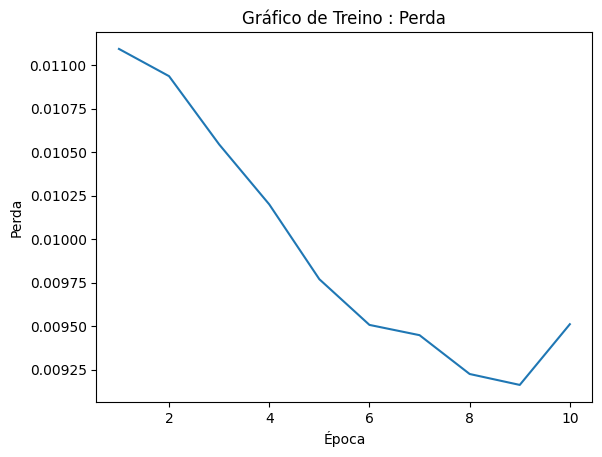

In [14]:
epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.title('Gráfico de Treino : Perda')
plt.plot(epoch, loss_test_history, label='loss')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.show()

## Criando o Detector de Anomalia
Com o autoencoder pronto é preciso estudar qual é a média de erro para as fraudes e não fraudes.

In [15]:
# Pegando o dataset de teste e removendo a classe
X_test = X_test.reset_index(drop=True)
test = X_test.drop('Class', axis=1)

# Transformando o dataset em tensor e passando no modelo
test = torch.tensor(test.values.astype(np.float32))
pred = model(test)

# Calculando a loss individual de cada exemplo
mse = np.mean(np.power(test.detach().numpy() - pred.detach().numpy(), 2), axis=1)

print("Média da loss dos exemplos normais: " + str(np.mean(mse[X_test.index[X_test['Class'] == 0]])))
print("Média da loss dos exemplos com fraude: " + str(np.mean(mse[X_test.index[X_test['Class'] == 1]])))


Média da loss dos exemplos normais: 0.5962136
Média da loss dos exemplos com fraude: 22.535057


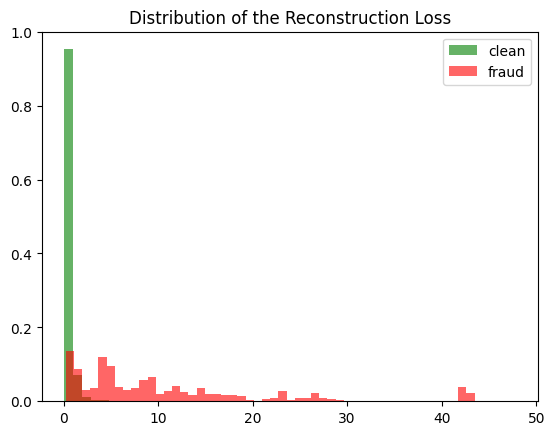

In [16]:
clean = mse[X_test.index[X_test['Class'] == 0]]
fraud = mse[X_test.index[X_test['Class'] == 1]]

# Removendo outliers para visualização do gráfico
clean = np.delete(clean, np.where(clean >= 50))
fraud = np.delete(fraud, np.where(fraud >= 50))

plt.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
plt.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the Reconstruction Loss")
plt.legend()
plt.show()


### Função para Prever Anomalia
Define se é fraude ou não.

In [17]:
def predict_anomaly(model, X, threshold):
    pred = model(X)
    mse = np.mean(np.power(X.detach().numpy() - pred.detach().numpy(), 2), axis=1)
    result = np.where(mse > threshold, 1, 0)
    return result

## Resultados
Por fim, ao rodar algumas vezes com valores diferentes de threshold para o erro o valor 3 foi o que melhor balanceou as métricas definidas. Dependendo do contexto vale a pena abaixar ainda mais o threshold caso seja necessário encontrar todas as transações fraudulentas e não tenha problema obter muitos falsos positivos, pois quanto menor o threshold pior fica a precisão das fraudes.

OBS: No caso do contexto de cartões de crédito talvez seja melhor reduzir ainda mais o threshold para não passarem fraudes não detectadas

Clean:
	Precision: 0.9984007676315368
	Recall: 0.9881117774299633
	F1-Score: 0.993229627010783

Fraud:
	Precision: 0.37291280148423006
	Recall: 0.8170731707317073
	F1-Score: 0.5121019108280254

Acurácia: 0.9866445819893644

MCC: 0.5467870672393447


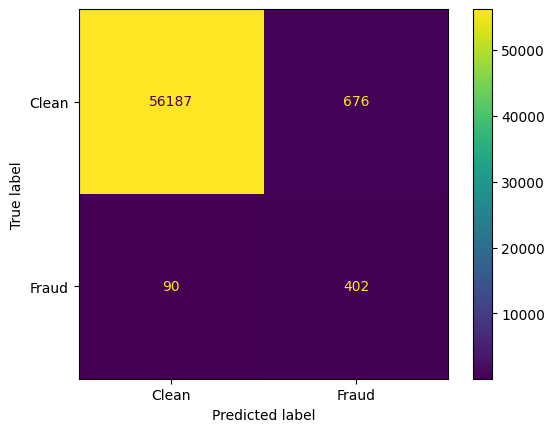

In [18]:
pred = predict_anomaly(model, test, 3)

cm = confusion_matrix(X_test['Class'], pred)
ConfusionMatrixDisplay(cm, display_labels= ['Clean', 'Fraud']).plot()

report = classification_report(X_test['Class'], pred, output_dict=True)
print("Clean:\n\tPrecision: " + str(report['0']['precision']) + "\n\tRecall: " + str(report['0']['recall']) + "\n\tF1-Score: " + str(report['0']['f1-score']))
print("\nFraud:\n\tPrecision: " + str(report['1']['precision']) + "\n\tRecall: " + str(report['1']['recall']) + "\n\tF1-Score: " + str(report['1']['f1-score']))
print("\nAcurácia: " + str(report['accuracy']))

mcc = matthews_corrcoef(X_test['Class'], pred)
print("\nMCC: " + str(mcc))